# Imports

In [1]:
# Imports and GPU check
%matplotlib inline
import os
import random
import time
from tqdm import tqdm
from itertools import product
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary
import torch
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau


from sklearn.model_selection import train_test_split

# Check for GPU availability
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Reproducibility
Achieving reproducible results is a cornerstone of scientific research. 

In the context of Deep Learning, this means ensuring that a model will produce the same results on the same data, regardless of when or where it is run. This is challenging due to the inherent randomness in model initialization and data shuffling. 
To avoid (or minimize) it, we fix the random seed across all libraries that generate random numbers.

In [16]:
def set_seed(seed=7):
    """Sets the seed for reproducibility."""
    # Python RNG
    random.seed(seed)

    # PyTorch RNGs
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    # Numpy RNG
    np.random.seed(seed)

    # OS RNG
    os.environ["PYTHONHASHSEED"] = str(seed)


def worker_init_fn(worker_id):
    """Ensure that the data loading process is deterministic."""
    np.random.seed(np.random.get_state()[1][0] + worker_id)


set_seed(7)

## Initial Hyperparameters

In [31]:
# Hyperparameters
batch_size = 60
dataset_size = 2000  # Reduced dataset size for quicker training

epochs = 50
learning_rate = 0.001

# Dataset

The dataset for this project, obtained from the PizzaGAN project at MIT and accessible on [this website](http://pizzagan.csail.mit.edu/), includes pizza images with labeled toppings. Over 38 million #pizza posts on Instagram were initially filtered to acquire approximately half a million images, with undesired content removed. After this, it was diminished even further until 9,213 pictures with corresponding annotations were left. 

In [18]:
# Import the csv from path.
label_path = "data/pizza_data/imageLabels.txt"
column_path = 'data/pizza_data/categories.txt'
image_path = "data/pizza_data/images"

df = pd.read_csv(label_path, sep = '  ', header = None)
df.columns = open(column_path, 'r').read().split('\n')[:-1]
classes = len(open(column_path, 'r').read().split('\n')[:-1])+1
open(column_path, 'r').close()


# Encode a label of pizzas without labeled toppings.
df["plain"] = 0
df["image_name"] = df.apply(lambda x: os.path.join(image_path, str(x.name+1).zfill(5)+'.jpg'), axis = 1)
df.loc[df.iloc[:, 1:-1].max(axis=1) == 0, "plain"] = 1

# Split the data in training and validation.
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=7)
train_df

/var/folders/_9/jnsf4lss7xjbfmffjcqt5ksc0000gn/T/ipykernel_16022/105247884.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(label_path, sep = '  ', header = None)


,Pepperoni,Bacon,Mushrooms,Onions,Peppers,Black olives,Tomatoes,Spinach,Fresh basil,Arugula,Broccoli,Corn,Pineapple,plain,image_name
2091,0,1,0,1,0,0,1,0,0,0,0,0,0,0,data/pizza_data/images/02092.jpg
7311,0,0,0,0,0,1,0,0,0,0,0,0,0,0,data/pizza_data/images/07312.jpg
2855,0,0,1,0,0,0,1,0,1,0,0,0,0,0,data/pizza_data/images/02856.jpg
8371,0,0,0,0,0,0,0,0,1,0,0,0,0,0,data/pizza_data/images/08372.jpg
4000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,data/pizza_data/images/04001.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372,0,1,0,0,0,0,0,0,1,0,0,0,0,0,data/pizza_data/images/01373.jpg
919,0,0,0,1,0,0,0,0,0,0,0,0,0,0,data/pizza_data/images/00920.jpg
4307,0,0,0,0,0,0,1,0,0,0,0,0,0,0,data/pizza_data/images/04308.jpg
5699,0,0,0,0,0,0,0,0,0,0,0,0,0,1,data/pizza_data/images/05700.jpg


## Set up Dataset

In [19]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_name = self.dataframe.iat[idx, -1]  # the path is in the first column
        image = Image.open(image_name).convert("RGB")
        labels = torch.tensor(
            self.dataframe.drop('image_name', axis = 1).iloc[idx].values.astype("float32")
        )  # Convert to tensor

        # Transform the image
        if self.transform:
            image = self.transform(image)

        return image, labels
    
    

## Create DataLoaders

In [32]:
# Define transformation (convert to tensor)
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

# Create dataset instances
full_train_dataset = ImageDataset(dataframe=train_df, transform=transform)
test_dataset = ImageDataset(dataframe=test_df, transform=transform)

# Create the dataloaders for training and validation
train_loader = DataLoader(
    dataset=full_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    worker_init_fn=worker_init_fn
   # num_workers=4,  # Optimal for a dual-core with hyper-threading
    #pin_memory=True  # This is more beneficial if you are using a GPU
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn
   # num_workers=4
)

# Reducing the dataset size
indices = list(range(dataset_size))
train_dataset = Subset(full_train_dataset, indices)

print(
    f"Full train set size: {len(full_train_dataset)} - Reduced train set size: {len(train_dataset)} - Test set size: {len(test_dataset)}"
)

Full train set size: 7370 - Reduced train set size: 2000 - Test set size: 1843


In [21]:
# Quick check to see if the DataLoader is working properly
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i}: Images shape {images.shape}, Labels shape {labels.shape}")
    if i == 1:  # Check the first two batches and then stop
        break


Batch 0: Images shape torch.Size([60, 3, 256, 256]), Labels shape torch.Size([60, 14])
Batch 1: Images shape torch.Size([60, 3, 256, 256]), Labels shape torch.Size([60, 14])


### Testing

Let's normalize the input data, to improve the learning process, by using Standard Normalization.
we first need to calculate the mean and variance of the pixel values across the entire training dataset. These statistics are then used to normalize both the training and validation/test datasets. 

In [22]:
full_train_dataset[0][0]

tensor([[[0.0902, 0.0902, 0.0902,  ..., 0.4824, 0.5294, 0.5765],
         [0.0902, 0.0902, 0.0902,  ..., 0.5216, 0.5529, 0.5765],
         [0.0902, 0.0902, 0.0941,  ..., 0.5373, 0.5529, 0.5725],
         ...,
         [0.6549, 0.5882, 0.5765,  ..., 0.0706, 0.0706, 0.0784],
         [0.6392, 0.5765, 0.5490,  ..., 0.0784, 0.0824, 0.0863],
         [0.6196, 0.5647, 0.5490,  ..., 0.0784, 0.0863, 0.0863]],

        [[0.0667, 0.0667, 0.0667,  ..., 0.3333, 0.4000, 0.4471],
         [0.0667, 0.0667, 0.0667,  ..., 0.3804, 0.4314, 0.4549],
         [0.0667, 0.0667, 0.0706,  ..., 0.4118, 0.4471, 0.4667],
         ...,
         [0.5490, 0.4471, 0.4275,  ..., 0.0431, 0.0431, 0.0510],
         [0.5137, 0.4078, 0.3686,  ..., 0.0510, 0.0588, 0.0588],
         [0.4314, 0.3608, 0.3608,  ..., 0.0549, 0.0627, 0.0627]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.2980, 0.3922, 0.4431],
         [0.0196, 0.0196, 0.0196,  ..., 0.3569, 0.4157, 0.4392],
         [0.0196, 0.0196, 0.0235,  ..., 0.3765, 0.4039, 0.

In [23]:
test_df.loc[4315]

Pepperoni                                      1
Bacon                                          0
Mushrooms                                      0
Onions                                         1
Peppers                                        0
Black olives                                   0
Tomatoes                                       0
Spinach                                        0
Fresh basil                                    0
Arugula                                        0
Broccoli                                       0
Corn                                           0
Pineapple                                      1
plain                                          0
image_name      data/pizza_data/images/04316.jpg
Name: 4315, dtype: object

## Mean& Variance

In [33]:
def calculate_mean_and_variance(loader):
    mean = 0.0
    variance = 0.0
    total_images = 0
    
    for iteration in tqdm(iter(loader)):
        images = iteration[0]
        # Rearrange batch to be the shape of [B, C, W * H]
        images = images.view(images.size(0), images.size(1), -1)
        # Update total_images
        total_images += images.size(0)
        # Compute mean and variance here
        mean += images.mean(2).sum(0)
        variance += images.var(2).sum(0)

    # Final mean and variance
    mean /= total_images
    variance /= total_images

    return mean, variance


# Assuming train_loader is defined and loaded
mean, variance = calculate_mean_and_variance(train_loader)
std = variance.sqrt()

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

  0%|          | 0/123 [00:00<?, ?it/s]

100%|██████████| 123/123 [04:38<00:00,  2.27s/it]

Mean: tensor([0.6236, 0.4790, 0.3629])
Standard Deviation: tensor([0.2324, 0.2434, 0.2432])


Furthermore, we need to add the input normalization.

## Input Normalization

In [34]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),  # Normalize images
    ]
)

# Create dataset instances
full_train_dataset = ImageDataset(dataframe=train_df, transform=transform)
test_dataset = ImageDataset(dataframe=test_df, transform=transform)

# Create the dataloaders for training and validation
train_loader = DataLoader(
    dataset=full_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    worker_init_fn=worker_init_fn,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

# Reducing the dataset size
indices = list(range(dataset_size))
train_dataset = Subset(full_train_dataset, indices)

print(
    f"Full train set size: {len(full_train_dataset)} - Reduced train set size: {len(train_dataset)} - Test set size: {len(test_dataset)}"
)

Full train set size: 7370 - Reduced train set size: 2000 - Test set size: 1843


# Input visualization -- DOES THIS WORK CORRECTLY?

Let's visualize a set of images from the dataset.

Labels: Peppers
Labels: Black olives
Labels: Tomatoes


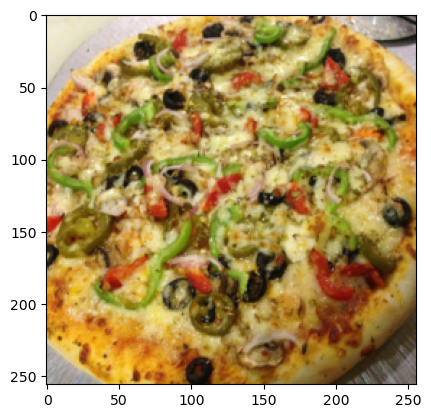

Labels: plain


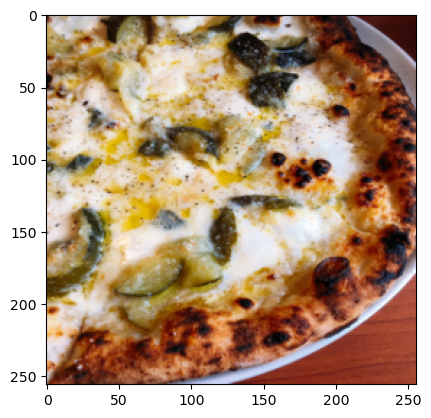

Labels: plain


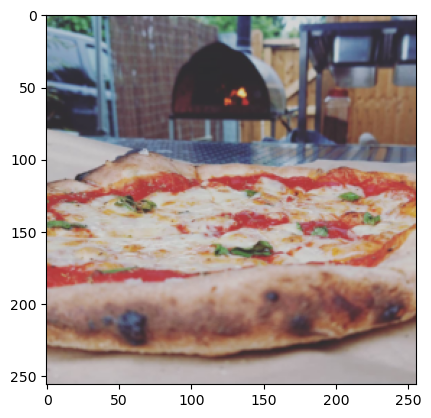

Labels: Spinach


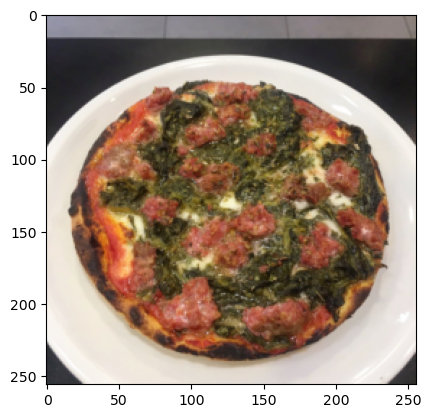

Labels: Mushrooms
Labels: Fresh basil


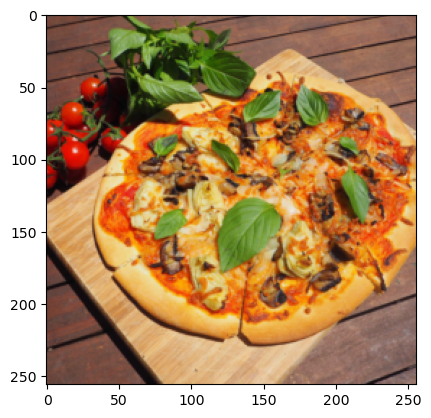

In [35]:
def denormalize(img, mean, std):
    """Denormalizes an image to its original form using mean and std"""
    mean = (
        torch.tensor(mean).reshape(-1, 1, 1)
        if not isinstance(mean, torch.Tensor)
        else mean.reshape(-1, 1, 1)
    )
    std = (
        torch.tensor(std).reshape(-1, 1, 1)
        if not isinstance(std, torch.Tensor)
        else std.reshape(-1, 1, 1)
    )
    denorm_img = img * std + mean  # Apply denormalization
    return denorm_img


def imshow(img, mean, std):
    """Shows an image by first denormalizing it"""
    img = denormalize(img, mean, std)  # Denormalize
    img = torch.clamp(img, 0, 255)  # Ensure the image is within [0, 255]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    return npimg


def display_labels(labels, classes):
    """Display labels given their indices and corresponding class names"""
    for idx, label in enumerate(labels):
        if label == 1:
            print(f"Labels: {classes[idx]}")


# Select random images and plot them with labels
classes = df.columns[:-1]

# Select random images and plot them with labels
num_images = 5
for i in random.sample(range(len(test_dataset)), num_images):
    image, labels = (
        test_dataset[i][0],
        test_dataset[i][1],
    )  # Ensure that you're accessing the tensor image

    # Display the labels
    display_labels(labels, classes)

    # Display the image
    imshow(image, mean, std)

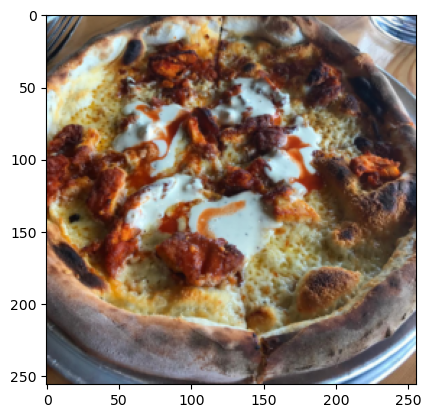

(3, 256, 256)

In [ ]:
imshow(test_dataset[0][0], mean, std).shape

# Basic Neural Network Architecture

### Basic Architecture 

Let's start our exploration with a basic Linear Model to establish a performance baseline.
 
This model, consisting of a single linear layer, is quick to train but typically underperforms on complex tasks due to its inability to capture non-linear relations in the training data.

In [36]:
class Linear_Model(nn.Module):
    def __init__(self, n_classes):
        super(Linear_Model, self).__init__()
        # Initialize the sequential model
        self.linear_stack = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.Dropout(p=0.5, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 16, kernel_size=5, stride=3, padding=2),
            nn.Dropout(p=0.2, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 1, kernel_size=7, stride=3, padding=2),
            nn.Dropout(p=0.3, inplace=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Flatten(),
            # Ensure that the input features to this layer are correctly calculated
            nn.Linear(784, 64),  # Make sure the '784' here is calculated based on the output size of the last conv layer
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Linear(64, n_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

# Assuming 'n_classes' is the correct integer value representing the number of classes
n_classes = len(df.columns[:-1])  # assuming df.columns[1:] contains the class names excluding 'image_name'
linear_model = Linear_Model(n_classes).to(device)
summary(linear_model, (3, 256, 256), device=device)
print('Device is ' + device)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
           Dropout-2         [-1, 64, 256, 256]               0
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4           [-1, 16, 86, 86]          25,616
           Dropout-5           [-1, 16, 86, 86]               0
              ReLU-6           [-1, 16, 86, 86]               0
            Conv2d-7            [-1, 1, 28, 28]             785
           Dropout-8            [-1, 1, 28, 28]               0
         LeakyReLU-9            [-1, 1, 28, 28]               0
          Flatten-10                  [-1, 784]               0
           Linear-11                   [-1, 64]          50,240
        LeakyReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 14]             910
          Sigmoid-14                   

## Basic Working Model

In [37]:
# Update model definition (remove sigmoid from the final layer if using BCEWithLogitsLoss)
class Linear_Model(nn.Module):
    def __init__(self, n_classes):
        super(Linear_Model, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Conv2d(64, 16, kernel_size=5, stride=3, padding=2),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=7, stride=3, padding=2),
            nn.Dropout(p=0.1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Flatten(),
            nn.Linear(784, 64),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(64, n_classes)  # No sigmoid here if using BCEWithLogitsLoss
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits
n_classes = len(df.columns[1:])  # assuming df.columns[1:] contains the class names excluding 'image_name'

model = linear_model
# Update the loss function
criterion = nn.BCEWithLogitsLoss()  # Use this for multi-label classification
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [38]:
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(10):
    print('Starting epoch...')
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print(f"Processed batch {i}, Loss: {loss.item()}")
    #scheduler.step()  # Decay learning rate

Starting epoch...
Processed batch 0, Loss: 0.9118207693099976
Processed batch 1, Loss: 0.8751717209815979
Processed batch 2, Loss: 0.7900815010070801
Processed batch 3, Loss: 0.7117673754692078
Processed batch 4, Loss: 0.6940091848373413
Processed batch 5, Loss: 0.6931641101837158
Processed batch 6, Loss: 0.6931477189064026
Processed batch 7, Loss: 0.6931471824645996
Processed batch 8, Loss: 0.6931471824645996
Processed batch 9, Loss: 0.6931471824645996
Processed batch 10, Loss: 0.6931471824645996
Processed batch 11, Loss: 0.6931471824645996
Processed batch 12, Loss: 0.6931471824645996
Processed batch 13, Loss: 0.6931471824645996
Processed batch 14, Loss: 0.6931471824645996
Processed batch 15, Loss: 0.6931471824645996
Processed batch 16, Loss: 0.6931471824645996
Processed batch 17, Loss: 0.6931471824645996
Processed batch 18, Loss: 0.6931471824645996
Processed batch 19, Loss: 0.6931471824645996
Processed batch 20, Loss: 0.6931471824645996
Processed batch 21, Loss: 0.6931471824645996
Pr

KeyboardInterrupt: 

## Slightly more Advanced but slower model

In [39]:
import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

class EnhancedCNN(nn.Module):
    def __init__(self, n_classes):
        super(EnhancedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # First Conv Layer
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Output: (256 - 3 + 2*1)/1 + 1 = 256
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 256/2 = 128

            # Second Conv Layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Output: (128 - 3 + 2*1)/1 + 1 = 128
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 128/2 = 64

            # Third Conv Layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Output: (64 - 3 + 2*1)/1 + 1 = 64
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 64/2 = 32

            # Fourth Conv Layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Output: (32 - 3 + 2*1)/1 + 1 = 32
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 32/2 = 16

            nn.Flatten(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 16 * 16, 512),  # Correctly adjust the flattened dimensions
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Assuming you have the right n_classes and train_loader setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedCNN(n_classes).to(device)  # Ensure n_classes is correctly defined based on your dataset

# Setup optimizer, loss function, and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


In [ ]:

# Training loop
print('Starting training...')
for epoch in range(10):  # Adjust the number of epochs as needed
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:  # Print loss every 10 batches
            print(f"Epoch {epoch+1}, Batch {i}, Loss: {loss.item()}")
    scheduler.step()  # Adjust the learning rate after each epoch

print('Training completed.')


### TEST

In [18]:
class OptimizedCNN(nn.Module):
    def __init__(self, n_classes):
        super(OptimizedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Flatten(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Assuming you have the right n_classes and train_loader setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OptimizedCNN(n_classes).to(device)  # Ensure n_classes is correctly defined based on your dataset

# Setup optimizer, loss function, and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
for epoch in range(2):  # Number of epochs
    print(f'Starting epoch {epoch + 1}/{2}...')
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:  # Print loss every 10 batches
            print(f"Epoch {epoch + 1}, Batch {i}, Loss: {loss.item()}")
    scheduler.step()  # Adjust the learning rate after each epoch
    print(f'Ending epoch {epoch + 1}/{2}')


## Tried to implement early stoping DOESNT WORK

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import os
from PIL import Image

# Define the advanced CNN architecture
class AdvancedCNN(nn.Module):
    def __init__(self, n_classes):
        super(AdvancedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # Conv Layer
            nn.BatchNorm2d(32),                       # Batch Normalization
            nn.ReLU(),                                # Activation
            nn.MaxPool2d(2, 2),                       # Pooling
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Initialize model, optimizer, and loss function
model = AdvancedCNN(n_classes).to(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

# Scheduler for adjusting learning rate
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Early Stopping mechanism
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print("EarlyStopping counter: {self.counter} out of {self.patience}")
                self.early_stop = True

early_stopper = EarlyStopping(patience=5, verbose=True)

# Training loop
def train_model(epochs, model, train_loader, criterion, optimizer, scheduler, early_stopper):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step(total_loss / len(train_loader))  # Adjust the learning rate
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')

        if early_stopper.early_stop:
            print("Early stopping triggered")
            break

train_model(epochs, model, train_loader, criterion, optimizer, scheduler, early_stopper)


## OLD

In [ ]:
# Linear Model
class Linear_Model(nn.Module):
    def __init__(self, n_classes):
        super(Linear_Model, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.Dropout(p = 0.5, inplace = True),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 16, kernel_size= 5, stride = 3, padding = 2),
            torch.nn.Dropout(p = 0.2, inplace = True),
            nn.ReLU(inplace = True),
            nn.Conv2d(16, 1, kernel_size = 7, stride = 3, padding = 2),
            torch.nn.Dropout(p=0.3, inplace = True),
            nn.LeakyReLU(negative_slope=0.2, inplace = True),
            nn.Flatten(),
            nn.Linear(784, 64), 
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Linear(64, n_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits


linear_model = Linear_Model(classes).to(device)
summary(linear_model, (3,256,256), device = device)
print('Device is ' + device)

Show more model information regarding parameters.

In [22]:
# Calculate and print the number of parameters per layer
total_param_num = 0
for name, param in linear_model.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")
    total_param_num += param.numel()

print(f"\nTotal number of parameters: {total_param_num}")

Layer: linear_stack.0.weight, Parameters: 1728
Layer: linear_stack.0.bias, Parameters: 64
Layer: linear_stack.3.weight, Parameters: 25600
Layer: linear_stack.3.bias, Parameters: 16
Layer: linear_stack.6.weight, Parameters: 784
Layer: linear_stack.6.bias, Parameters: 1
Layer: linear_stack.10.weight, Parameters: 50176
Layer: linear_stack.10.bias, Parameters: 64
Layer: linear_stack.12.weight, Parameters: 896
Layer: linear_stack.12.bias, Parameters: 14

Total number of parameters: 79343


## Loss function and optimizer

When choosing a loss function and an optimizer for a neural network, it's important to consider the specific task at hand. 

For classification tasks, Cross Entropy Loss and optimizers like SGD or Adam are common choices. 

In [19]:
model = linear_model

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.1)

## Model Training

The training loop is where the model learns from the data. In each epoch, the model makes predictions, calculates the error (loss), and uses backpropagation to adjust the weights. 

### Training Process Overview

During training, for each batch of data, the following steps occur:
1. **Forward Pass:** The model computes predictions based on the input data.
2. **Compute Loss:** The difference between the predictions and the actual labels is calculated using the loss function.
3. **Backward Pass:** The model backpropagates the loss to compute the gradients of the loss with respect to each parameter.
4. **Update Parameters:** The optimizer uses the gradients calculated during the backward pass to update the model's parameters.

In [20]:
# Training and Validation Loop
for epoch in tqdm(range(epochs)):
    print('starting epoch...')
    # Training Phase
    model.train()  # Set the model to training mode

    for images, labels in train_loader:
        images, labels = images.to(device), torch.max(labels, 1)[1].to(
            device
        )  # Move data to the appropriate device

        optimizer.zero_grad()  # Zero the gradients to prevent accumulation
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the model

  0%|          | 0/50 [00:00<?, ?it/s]

starting epoch...


  0%|          | 0/50 [00:45<?, ?it/s]


KeyboardInterrupt: 

In [159]:
criterion(torch.Tensor([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5, 0.5,0.5,0.5,0.5,0.5,0.5]).reshape((1,18)), torch.Tensor([1,0,1,0,1,1,0,1,0,1,1,0,1,1,0,1,1,0]).reshape((1,18)))

tensor(31.7941)

In [150]:
torch.Tensor([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5, 0.5,0.5,0.5,0.5,0.5,0.5])

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000])

In [151]:
torch.Tensor([1,0,1,0,1,1,0,1,0,1,1,0,1,1,0,1,1,0])

tensor([1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.])

In [ ]:
#@title
def train_model(model, train_sampler, optimizer, loss_function):
  # Lets keep track of all the losses:
  losses = []
  # Put the model in train mode:
  model.train()
  # Feed all the batches one by one:
  for batch in tqdm(train_sampler):
    # Get a batch:
    x, y = batch
    # Making sure our samples are stored on the same device as our model:
    x, y = x.to(device), y.to(device)
    # Get predictions:
    predictions = model.forward(x)
    loss = loss_function(predictions, y)
    losses.append(loss)
    # We first need to make sure we reset our optimizer at the start.
    # We want to learn from each batch seperately, 
    # not from the entire dataset at once.
    optimizer.zero_grad()
    # We now backpropagate our loss through our model:
    loss.backward()
    # We then make the optimizer take a step in the right direction.
    optimizer.step()
  return losses

def test_model(model, test_sampler, loss_function):
  # Setting the model to evaluation mode:
  model.eval()
  losses = []
  # We need to make sure we do not update our model based on the test data:
  with torch.no_grad():
    for (x, y) in tqdm(test_sampler):
      # Making sure our samples are stored on the same device as our model:
      x = x.to(device)
      y = y.to(device)
      prediction = model.forward(x)
      loss = loss_function(prediction, y)
      losses.append(loss)
  return losses

class BatchSampler():
  """
  Implements an iterable which given a torch dataset and a batch_size
  will produce batches of data of that given size. The batches are
  returned as tuples in the form (images, labels).
  Can produce balanced batches, where each batch will have an equal 
  amount of samples from each class in the dataset. If your dataset is heavily
  imbalanced, this might mean throwing away a lot of samples from 
  over-represented classes!
  """

  def __init__(self, batch_size, dataset, balanced=False):
    self.batch_size = batch_size
    self.dataset = dataset
    self.balanced = balanced
    if self.balanced:
      # Counting the ocurrence of the class labels:
      unique, counts = np.unique(self.dataset.targets, return_counts=True) 
      indexes = []
      # Sampling an equal amount from each class:
      for i in range(len(unique)):
        indexes.append(np.random.choice(np.where(self.dataset.targets == i)[0], size=counts.min(), replace=False))
      # Setting the indexes we will sample from later:
      self.indexes = np.concatenate(indexes)
    else:
      # Setting the indexes we will sample from later (all indexes):
      self.indexes = [i for i in range(len(dataset))]


  def __len__(self):
    return (len(self.indexes) // self.batch_size) + 1
  
  def shuffle(self):
    # We do not need to shuffle if we use the balanced sampling method.
    # Shuffling is already done when making the balanced samples.
    if not self.balanced:
      random.shuffle(self.indexes)
    
  def __iter__(self):
    remaining = False
    self.shuffle()
    # Go over the datset in steps of 'self.batch_size':
    for i in range(0, len(self.indexes), self.batch_size):
        imgs, labels = [], []
        # If our current batch is larger than the remaining data, we quit:
        if i + self.batch_size > len(self.indexes):
          remaining = True
          break
        # If not, we yield a complete batch:
        else:
          # Getting a list of samples from the dataset, given the indexes we defined:
          X_batch = [self.dataset[self.indexes[k]][0] for k in range(i, i + self.batch_size)]
          Y_batch = [self.dataset[self.indexes[k]][1] for k in range(i, i + self.batch_size)]
          # Stacking all the samples and returning the target labels as a tensor:
          yield torch.stack(X_batch).float(), torch.stack(Y_batch).float()
    # If there is still data left that was not a full batch:
    if remaining:
      # Return the last batch (smaller than batch_size):
      X_batch = [self.dataset[self.indexes[k]][0] for k in range(i, len(self.indexes))]
      Y_batch = [self.dataset[self.indexes[k]][1] for k in range(i, len(self.indexes))]
      yield torch.stack(X_batch).float(), torch.stack(Y_batch).float()

In [ ]:
train_sampler = BatchSampler(batch_size=batch_size, dataset=train_dataset, balanced=False)
test_sampler = BatchSampler(batch_size=batch_size, dataset=test_dataset, balanced=False)

mean_losses_train = []
mean_losses_test = []
accuracies = []
for e in range(epochs):
  # Training:
  losses = train_model(model, train_sampler, optimizer, criterion)
  # Calculating and printing statistics:
  mean_loss = sum(losses) / len(losses)
  mean_losses_train.append(mean_loss)
  print(f'\nEpoch {e + 1} training done, loss on train set: {mean_loss}\n')

  # Testing:
  losses = test_model(model, test_sampler, criterion)
  # Calculating and printing statistics:
  mean_loss = sum(losses) / len(losses)
  mean_losses_test.append(mean_loss)
  print(f'\nEpoch {e + 1} testing done, loss on test set: {mean_loss}\n')
  with torch.no_grad():
    correct = 0
    count = 0
    for (x, y) in test_sampler:
      # Making sure our samples are stored on the same device as our model:
      x = x.to(device)
      y = y.to(device)
      prediction = model.forward(x)
      correct += sum((prediction.round() == y).all(dim = 1))
      count += len(y)
    accuracy = (correct/count).detach().cpu().numpy()
    accuracies.append(accuracy)
  fig, ax = plt.subplots()
  ax2 = ax.twinx()
  ax.plot(mean_losses_train, label='Train loss')
  ax.plot(mean_losses_test, label='Test loss')
  ax2.plot(accuracies, label = 'Accuracy', c = 'r')
  ax.legend(['Train loss', 'Test loss', 'Accuracy'])
  plt.show()

In [195]:
len(y)

30

In [188]:
model.forward(x).round()

tensor([[0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0

In [189]:
y

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0